<a href="https://colab.research.google.com/github/Maziger/master-generative-ai-with-llm/blob/main/Take_home_exam_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:

## 1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.

### Fine-tuning DestilBert

* Printing and logging settings
  * Wraps text and keeps notebook cleaner

In [1]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)
transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

* Load in the AG News dataset

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [4]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


* Tokenize the dataset

In [5]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [6]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [7]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00


In [8]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [9]:
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Prepare to push model to huggingface

In [12]:
from huggingface_hub import notebook_login

notebook_login()

* Train model

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
from transformers import AutoModelForSequenceClassification

batch_size = 32  # You can change this if you have a big or small GPU
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_DestilBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.260661,0.911842,0.911622
2,0.304900,0.244173,0.919079,0.919074


TrainOutput(global_step=626, training_loss=0.2795603694245457, metrics={'train_runtime': 780.9684, 'train_samples_per_second': 25.609, 'train_steps_per_second': 0.802, 'total_flos': 1875180164398464.0, 'train_loss': 0.2795603694245457, 'epoch': 2.0})

Model showcases an F1 score on the validation set of approx. 91%

* Test if the model works on a sample text

In [17]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="genaibook/classifier-chapter4",
    device="cuda",
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[{'label': 'Sports', 'score': 0.8631355166435242}]

In [18]:
# Get prediction for all samples
model_preds = pipe(list(tokenized_datasets["test"]["text"]))

# Get the dataset labels
references = tokenized_datasets["test"]["label"]

# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]
for pred, ref, text in zip(model_preds[:samples], references[:samples], texts):
    print(f"Predicted {pred['label']}; Actual {label_names[ref]};")
    print(text)

Predicted Business; Actual Business;
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted Sci/Tech; Actual Sci/Tech;
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted Sci/Tech; Actual Sci/Tech;
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


* Plot confusion matrix

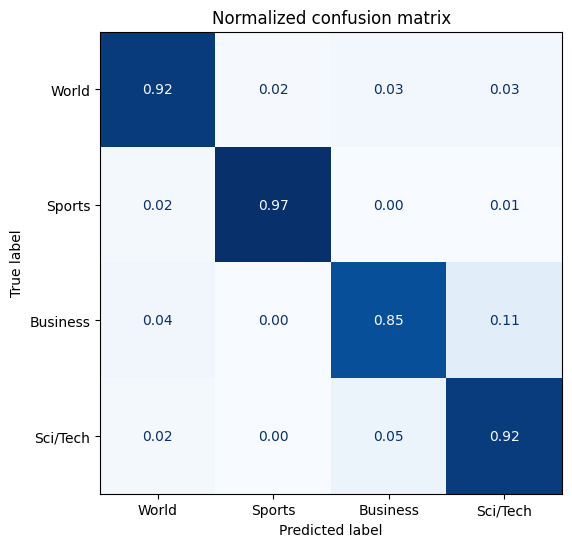

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

Noticeable that the Business category is sometimes confused with Sci/Tech (0.11).

In [20]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nment1_DestilBert/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...nment1_DestilBert/model.safetensors:  13%|#2        | 33.5MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment1_DestilBert/commit/cf17b511b053f465cd9563b85e741ae807131738', commit_message='Completed training', commit_description='', oid='cf17b511b053f465cd9563b85e741ae807131738', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment1_DestilBert', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment1_DestilBert'), pr_revision=None, pr_num=None)

### Error analysis

In [33]:
import torch
from torch.nn.functional import cross_entropy

# Set device (make sure this matches where your model is)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [38]:
# Create label mapping function
label_names = raw_train_dataset.features["label"].names
def label_int2str(label_int):
    return label_names[label_int]

# Simple approach: Process one example at a time
def forward_pass_single(example):
    # Prepare inputs for a single example (values are already tensors)
    inputs = {k: example[k].unsqueeze(0).to(device)
              for k in tokenizer.model_input_names if k in example}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, example["label"].unsqueeze(0).to(device),
                           reduction="none")

    return {"loss": loss.cpu().numpy()[0],
            "predicted_label": pred_label.cpu().numpy()[0]}

In [39]:
# Convert your test dataset to PyTorch tensors
tokenized_datasets["test"].set_format("torch",
                                     columns=["input_ids", "attention_mask", "label"])

In [40]:
# Process each example individually
print("Processing test dataset for error analysis...")
test_with_loss = tokenized_datasets["test"].map(forward_pass_single)

# Convert back to pandas for analysis
test_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test_with_loss[:][cols]

Processing test dataset for error analysis...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [44]:
# Convert label integers to strings
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [45]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1269,Philippines mourns dead in Russian school sieg...,Sci/Tech,World,6.543804
6185,Special to ESPN.com It #39;s the age old quest...,Business,Sports,6.336563
912,Bryant Makes First Appearance at Trial (AP) AP...,Sci/Tech,Sports,6.312724
707,Dominicans' Swift Step Into Crisis SANTO DOMIN...,Business,World,6.240247
7228,Indonesian diplomats asked to help improve RI ...,Business,World,6.147722
4300,City Series-ly wounded With the Yanks out of t...,Sports,Business,6.147202
1197,World briefs LONDON - A man wielding a machete...,Business,World,6.138808
2126,Bush Scraps Most U.S. Sanctions on Libya (Reut...,Sci/Tech,World,6.032561
1712,Tyncastle sale gets official go ahead Of the v...,Sports,Business,5.964531
2833,Man arrested for fatally stabbing elderly pare...,Sci/Tech,World,5.951996


## 2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.

## 3. Compare the test set performance of the two fine-tuned models.

## 4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

# Assignment 2